In [316]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import random

df_data = pd.read_csv("weight-height.csv")
df_data

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801
...,...,...,...
9995,Female,66.172652,136.777454
9996,Female,67.067155,170.867906
9997,Female,63.867992,128.475319
9998,Female,69.034243,163.852461


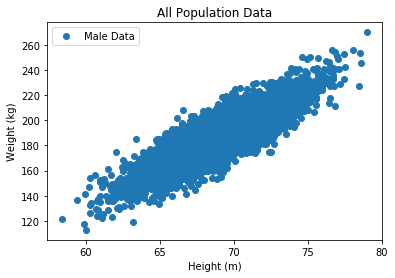

In [317]:
df_male_data = df_data[df_data.Gender == 'Male'].copy()

fig, ax = plt.subplots()
ax.set_title('All Population Data')
ax.set_xlabel('Height (m)')
ax.set_ylabel('Weight (kg)')
ax.plot('Height', 'Weight', 'o', data = df_male_data, label = 'Male Data')
ax.legend(loc = 'upper left')
plt.show()

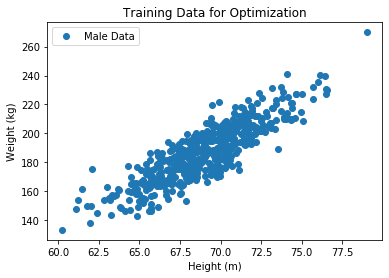

In [352]:
# Separate the height-weight data into training and testing sets through random sampling of points

all_heights = df_male_data['Height'].to_numpy() # 5000 points
all_weights = df_male_data['Weight'].to_numpy()
training_size = int(all_heights.shape[0]/10) # 500 points
training_indices = random.sample(np.arange(all_heights.shape[0]).tolist(), training_size)
x = np.array([all_heights[i] for i in training_indices])
y = np.array([all_weights[i] for i in training_indices])

fig, ax = plt.subplots()
ax.set_title('Training Data for Optimization')
ax.set_xlabel('Height (m)')
ax.set_ylabel('Weight (kg)')
ax.plot(x, y, 'o', label = 'Male Data')
ax.legend(loc = 'upper left')
plt.show()

In [353]:
def calc_loss(x, y, weights, indices_chosen = None): # Least squares loss function
    loss = 0
    if (indices_chosen is None): # i.e., no subset of data specified
        indices_chosen = np.arange(x.shape[0])
    for i in indices_chosen:
        y_pred = np.dot(weights, [1, x[i]])
        loss += (y[i] - y_pred)**2
    return loss

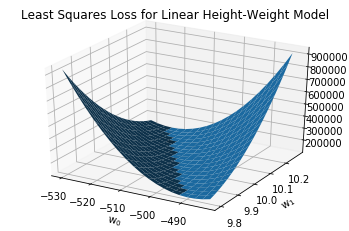

In [354]:
# Plot the loss surface as a function of the two weights
# For this problem, it's helpful to visualize the data and loss terrain

w0_min = -530
w0_max = -480

w1_min = 9.8
w1_max = 10.3

resolution = 20

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title(r'Least Squares Loss for Linear Height-Weight Model')
ax.set_xlabel(r'w$_0$')
ax.set_ylabel(r'w$_1$')

w0 = np.arange(w0_min, w0_max, (w0_max - w0_min)/resolution)
w1 = np.arange(w1_min, w1_max, (w1_max - w1_min)/resolution)
W0, W1 = np.meshgrid(w0, w1)
l = np.array([calc_loss(x, y, [w0, w1]) for w0, w1 in zip(np.ravel(W0), np.ravel(W1))])
L = l.reshape(W0.shape)

ax.plot_surface(W0, W1, L)

plt.show()

In [376]:
def calc_loss_grad(x, y, weights, MB_size = None, spacing = 0.0001):
    # Finite difference along each weight's direction
    loss_grad = []
    for dim in np.arange(weights.shape[0]):
        increment = np.zeros(weights.shape[0])
        increment[dim] = spacing
        if (MB_size is None):
            indices_chosen = None
        else:
            indices_chosen = random.sample(np.arange(x.shape[0]).tolist(), MB_size)
        loss_right = calc_loss(x, y, weights + increment, indices_chosen)
        loss_left = calc_loss(x, y, weights - increment, indices_chosen)
        loss_grad.append((loss_right - loss_left)/(2*spacing))
    return np.array(loss_grad)
    
def update_weights(x, y, weights, t, MB_size = None, eta = 10**(-5)):
    # Updates according to the loss gradient
    # MB_size governs wether the gradient is evaluated deterministically or stochastically
    if (t > 0):
        loss_grad = calc_loss_grad(x, y, weights, MB_size)
        weights = weights - eta*loss_grad
    loss = calc_loss(x, y, weights) # Total loss (i.e., no mini-batches here)
    d_iter = {'iter':t, 'weights':weights, 'loss':loss, 'MB_size':MB_size, 'eta':eta}
    return d_iter   

In [379]:
# Perform the SGD optimization at different step sizes and load results into a dataframe

df_iter = pd.DataFrame(data = {})
max_iter = 1000
MB_sizes = [1, 50, 100, 200]
initial_weights = np.array([-550, 10.4]) # w0, w1 as slope and intercept of line (converges near -500, -9.95)
t = 0

#--------------------------- Optimization starts here

for MB_size in MB_sizes:
    start_time = time.time()
    weights = initial_weights
    while (t < max_iter):
        d_iter = update_weights(x, y, weights, t, MB_size = MB_size, eta = 10**(-6))
        df_iter = pd.concat([df_iter, pd.DataFrame(data = [d_iter])])
        loss = d_iter['loss']
        weights = d_iter['weights']
        t += 1
    total_time = (time.time() - start_time) 
    print(f'Now finishing MB Size {MB_size} in {total_time} seconds')
    t = 0

#--------------------------- Optimization ends here

df_iter

Now finishing MB Size 1 in 4.074444055557251 seconds
Now finishing MB Size 50 in 4.508980989456177 seconds
Now finishing MB Size 100 in 5.240687131881714 seconds
Now finishing MB Size 200 in 6.432990789413452 seconds


,iter,weights,loss,MB_size,eta
0,0,"[-550.0, 10.4]",316213.010590,1,0.000001
0,1,"[-549.9999785266469, 10.408810942618139]",305083.238976,1,0.000001
0,2,"[-549.9999323885113, 10.41347763213879]",299338.008905,1,0.000001
0,3,"[-549.9999402183593, 10.416983890773636]",295090.638735,1,0.000001
0,4,"[-549.9999110780202, 10.419762139182128]",291766.233432,1,0.000001
...,...,...,...,...,...
0,995,"[-549.7471871897916, 10.723400691864544]",151582.694822,200,0.000001
0,996,"[-549.7479618636643, 10.587718472389051]",157799.088753,200,0.000001
0,997,"[-549.7452425970174, 10.740738603699528]",157135.438897,200,0.000001
0,998,"[-549.746945731956, 10.553446196766844]",173275.384526,200,0.000001


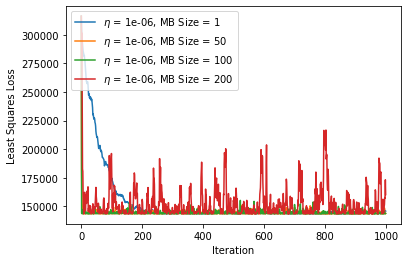

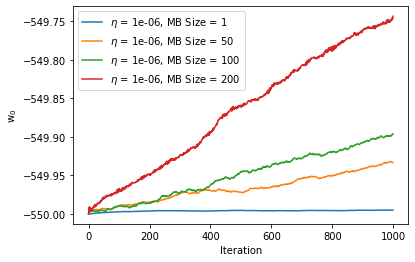

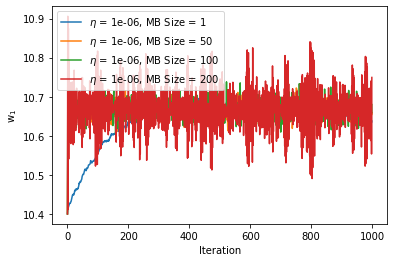

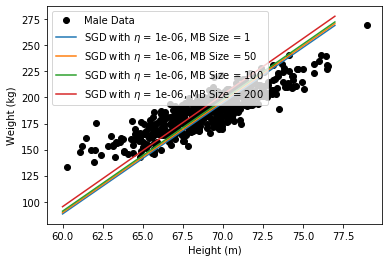

In [380]:
fig1, ax1 = plt.subplots()
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Least Squares Loss')

fig2, ax2 = plt.subplots()
ax2.set_xlabel('Iteration')
ax2.set_ylabel(r'w$_0$')

fig3, ax3 = plt.subplots()
ax3.set_xlabel('Iteration')
ax3.set_ylabel(r'w$_1$')

fig4, ax4 = plt.subplots()
ax4.set_xlabel('Height (m)')
ax4.set_ylabel('Weight (kg)')
ax4.plot(x, y, 'o', color = 'k', label = 'Male Data')

for MB_size in MB_sizes:
    
    df_iter_MB = df_iter[df_iter.MB_size == MB_size].copy()
    iterations = df_iter_MB['iter'].to_numpy()
    w0 = [df_iter_MB['weights'].to_numpy()[t][0] for t in np.arange(max_iter)]
    w1 = [df_iter_MB['weights'].to_numpy()[t][1] for t in np.arange(max_iter)]
    eta = df_iter_MB['eta'].to_numpy()[0]

    ax1.plot('iter', 'loss', data = df_iter_MB, label = f'$\eta$ = {eta}, MB Size = {MB_size}')
    ax2.plot(iterations, w0, label = f'$\eta$ = {eta}, MB Size = {MB_size}')
    ax3.plot(iterations, w1, label = f'$\eta$ = {eta}, MB Size = {MB_size}')
    ax4.plot(np.arange(60, 78), w0[-1] + np.arange(60, 78)*w1[-1], label = f'SGD with $\eta$ = {eta}, MB Size = {MB_size}')

ax1.legend(loc = 'upper left')
ax2.legend(loc = 'upper left')
ax3.legend(loc = 'upper left')
ax4.legend(loc = 'upper left')
plt.show()

In [ ]:
# COnsidering the lines on the above plot and the large oscillations, the weights don't appear converged.
# I currently calculate gradients using finite differences, which may be incorrect here.
# A more direct gradient calculation may be feasible, but some other issues come first.
# Consider a few possible sources of important bugs:

# 1) The learning rate eta may be too small to have the weights get anywhere. 
# Solution: try additional learning rates
# 2) The loss function values and gradients grow very large, especially with larger mini-batches
# or weights far from the loss minimum
# Solution: Choose a differnet loss function. Say, replace the sum over residuals with a weighted average